In [1]:
import pandas as pd 
from pathlib import Path
import numpy as np 
import matplotlib.pyplot as plt 
import xarray as xr
import hydroeval as he 
import seaborn as sns 
from tqdm import tqdm 

In [2]:
signature_dir = Path(r"C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\training_data_S1\signatures_nc_V1_output") 
 
fn_signatures = signature_dir / "S1_merged_signatures_v2-cleanup-1.csv"
# fn_signatures = signature_dir / "S1_merged_signatures_v2-cleanup-2.csv" 

df_signatures = pd.read_csv(fn_signatures, index_col = 0)

df_signatures

,Nm-all,Ns-all,N-gof-all,Lm-all,Ls-all,L-gof-all,Gu-all,Ga-all,Gev-gof-all,Gk-all,...,flv-seasonal_1,hf-f-all,hf-f-seasonal_1,hf-t-all,lf-f-all,lf-f-seasonal_1,lf-t-seasonal_1,pks-all,tag,dem_flag
ID,,,,,,,,,,,,,,,,,,,,,
6119010_11,102.035362,106.090645,0.0,4.221500,0.863208,0.0,54.306767,0.012089,0.0,0.925012,...,164.721008,0.590909,0.0,2.954545,0.363636,0.636364,4.481481,666.803894,6119010,0
6119010_12,100.917046,105.168777,0.0,4.209119,0.864435,0.0,53.603184,0.012195,0.0,0.920779,...,163.700439,0.590909,0.0,3.090909,0.363636,0.636364,4.518519,654.762268,6119010,0
6119010_13,0.544169,0.542255,0.0,-1.002645,0.867551,0.0,0.300217,2.365214,0.0,1.007072,...,266.693390,0.409091,0.0,1.727273,0.409091,0.636364,6.000000,3.131104,6119010,0
6119010_14,162.321777,138.910507,0.0,4.760090,0.835850,0.0,99.828016,0.009233,0.0,1.365474,...,317.679565,0.045455,0.0,0.136364,1.000000,0.545455,7.227273,723.082581,6119010,0
6119010_15,17.163115,16.641987,0.0,2.442999,0.888787,0.0,9.676133,0.077067,0.0,1.063609,...,248.398575,0.136364,0.0,0.363636,0.454545,0.500000,6.083333,98.092957,6119010,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6983350_96,522.018127,325.349060,0.0,6.080506,0.592225,0.0,375.648448,0.003942,0.0,2.574376,...,60.206692,0.000000,0.0,0.000000,0.111111,0.000000,0.000000,1890.435181,6983350,0
6983350_97,1.769354,1.644365,0.0,0.271318,0.743112,0.0,1.029579,0.779967,0.0,1.157798,...,73.878761,0.333333,0.0,1.000000,0.111111,0.555556,6.181818,10.525513,6983350,0
6983350_98,6.406629,5.884712,0.0,1.530997,0.797030,0.0,3.759185,0.217946,0.0,1.185247,...,92.737022,0.444444,0.0,1.000000,0.444444,0.444444,4.800000,33.151855,6983350,0


In [3]:
## column descriptors 
columns = df_signatures.columns.values 

## target value to predict 
target_col = ['target'] 

## should be omitted from dataset - but could be useful for easy selection 
## dem_flag only 1 for gauge values
non_feature_cols = ['n_buffer', 'tag', 'dem_flag'] 

## coord cols - could be ommitted from dataset, risk for overfitting
## and also takes away focus on selection based on timeseries
coord_cols = ['x', 'y', 'lat', 'lon']

## features that do not have to be transformed by subtraction 
## and cross-correlation properties, that are already a similarity property 
## as they are cross-correlation values of simulations and observations
non_similarity_cols = [col for col in columns if 'clag' in col]

feature_cols = [col for col in columns if (col not in non_feature_cols) & (not 'target' in col)]

## if coord_cols ommitted:
feature_cols = [col for col in feature_cols if col not in coord_cols] 

## columns on which to perform similarity calculations:
calc_cols = [col for col in feature_cols if col not in non_similarity_cols]

In [4]:
## depedentent on algorithm: check parameter distribution, transform to obtain a normal distribution

def plot_par(df, param = None):
    
    ## if no parameter specified, select a random parameter 
    if param == None:
        pars = df.columns 
        sample = np.random.randint(low=0, high= len(pars)-1 ) 
        param = pars[sample] 
    
    plt.figure(figsize=(3,3))
    plt.title(param)
    df[param].hist(bins=50)
    plt.yscale('log')


def plot_par_grid(df, nrows = 9, ncols = 9):

    plt.figure(figsize=(15,15))

    for i, col in enumerate(df.columns):
        plt.subplot(nrows, ncols, int(i+1))
        plt.title(col)
        df[col].hist(bins=50)
        plt.yscale('log')
    
    plt.suptitle('Parameter histograms')
    plt.tight_layout()

# plot_cols = [col for col in df_signatures.columns if (col not in coord_cols) & (col not in non_feature_cols) & (not 'target' in col)]
# plot_par_grid(df_signatures[plot_cols], nrows=9, ncols=9)

In [5]:
## calculate similarity per buffer 

def calc_similarity(df, buffer_col, calc_cols,
                   methods = ['diff']):
    
    df_out = df.copy() 
    
    buffer_idx = df[buffer_col].unique() 
    
    for ix in buffer_idx:
        df_buffer = df[ df[buffer_col] == ix] 
        
        cell_index = [row for row in df_buffer.index if not 'gauge' in row]
        gauge_index = [row for row in df_buffer.index if 'gauge' in row] 
        
        if 'diff' in methods:            
            for col in calc_cols:
                df_out.loc[cell_index, 'diff_{}'.format(col)] = df_out.loc[cell_index, col] - df_out.loc[gauge_index, col].values
        
        if 'abs' in methods:
            for col in calc_cols:
                 df_out.loc[cell_index, 'abs_{}'.format(col)] = ((df_out.loc[cell_index, col] - df_out.loc[gauge_index, col].values)**2)**0.5 
        
        if 'ratio' in methods:
            for col in calc_cols:
                df_out.loc[cell_index, 'rat_{}'.format(col)] = 1 - (( df_out.loc[cell_index, col] / (df_out.loc[gauge_index, col].values+1e-6)  )**2)**0.5
        
                    
    ## drop calc_cols
    df_out = df_out.drop(columns=calc_cols)
    
    gauge_idx = [row for row in df_out.index if 'gauge' in row] 
    return df_out.drop(index=gauge_idx)


df_similarity = calc_similarity(df_signatures, 'tag', calc_cols, methods=[
                                                                    'diff', 
#                                                                     'abs', 
#                                                                     'ratio'
                                                                        ])

df_similarity

,clag-0-all,clag-1-all,clag-0-seasonal_1,clag-1-seasonal_1,n_buffer,x,y,lat,lon,target,...,diff_fhv-seasonal_1,diff_flv-all,diff_flv-seasonal_1,diff_hf-f-all,diff_hf-f-seasonal_1,diff_hf-t-all,diff_lf-f-all,diff_lf-f-seasonal_1,diff_lf-t-seasonal_1,diff_pks-all
ID,,,,,,,,,,,,,,,,,,,,,
6119010_11,0.635464,0.544323,0.672078,0.537085,4.0,3422500.0,2352500.0,43.678226,-1.161527,0.0,...,8108.892578,-1091.800362,47.776888,0.454545,-0.045455,2.818182,0.318182,0.636364,4.481481,328.303894
6119010_12,0.635464,0.544067,0.671657,0.536465,4.0,3422500.0,2347500.0,43.633678,-1.152881,0.0,...,7921.990234,-1094.935036,46.756319,0.454545,-0.045455,2.954545,0.318182,0.636364,4.518519,316.262268
6119010_13,0.589989,0.522277,0.698611,0.582520,4.0,3422500.0,2342500.0,43.589130,-1.144252,0.0,...,-14805.981384,-713.167183,149.749269,0.272727,-0.045455,1.590909,0.363636,0.636364,6.000000,-335.368896
6119010_14,0.709440,0.570481,0.822756,0.639700,4.0,3422500.0,2337500.0,43.544575,-1.135641,0.0,...,11030.318359,-133.411201,200.735445,-0.090909,-0.045455,0.000000,0.954545,0.545455,7.227273,384.582581
6119010_15,0.612656,0.531497,0.700380,0.568576,4.0,3422500.0,2332500.0,43.500019,-1.127047,0.0,...,-11723.430176,-538.359810,131.454454,0.000000,-0.045455,0.227273,0.409091,0.500000,6.083333,-240.407043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6983350_95,0.203398,0.227645,0.419789,0.451424,4.0,6502500.0,2872500.0,45.141037,38.478489,0.0,...,-14710.986877,-476.378696,48.027616,0.777778,0.111111,1.555556,0.000000,0.555556,6.000000,-990.893250
6983350_96,0.574453,0.580212,0.581299,0.579456,4.0,6502500.0,2867500.0,45.099716,38.455753,0.0,...,-2752.287109,-400.673678,29.618272,0.000000,0.000000,0.000000,-0.111111,0.000000,0.000000,897.935181
6983350_97,0.234536,0.260122,0.485846,0.515676,4.0,6502500.0,2862500.0,45.058388,38.433064,0.0,...,-14548.157715,-373.953403,43.290342,0.333333,0.000000,1.000000,-0.111111,0.555556,6.181818,-981.974487


In [6]:
# print('After similarity calculation:')
# plot_cols = [col for col in df_similarity.columns if (col not in coord_cols) & (col not in non_feature_cols) & (not 'target' in col)]
# plot_par_grid(df_similarity[plot_cols] )

In [7]:
# start log transformation for given columns 

transform_cols = [ 'diff_Ga-all','diff_Ga-seasonal_1']

def log_transform(df, cols_to_transform):
    
    df_out = df.copy()
    
    checked_cols = [col for col in cols_to_transform if col in df_out.columns] 
    dismissed_cols = [col for col in cols_to_transform if col not in df_out.columns] 
    
    if len(dismissed_cols) > 0:
        print('Misspelled columns - check spelling: \n', dismissed_cols)
        
    for col in checked_cols:
        
        data = df_out[col].values 
            
        if min(data) <= 0:
            data += ((min(data))**2)**0.5 
        
#         df_out['log_{}'.format(col)] = np.log10(data + 10e-6)
        df_out['log_{}'.format(col)] = np.log(data + 10e-6)
        
    return df_out.drop(columns=checked_cols)

df_similarity = log_transform(df_similarity, transform_cols)

df_similarity

,clag-0-all,clag-1-all,clag-0-seasonal_1,clag-1-seasonal_1,n_buffer,x,y,lat,lon,target,...,diff_flv-seasonal_1,diff_hf-f-all,diff_hf-f-seasonal_1,diff_hf-t-all,diff_lf-f-all,diff_lf-f-seasonal_1,diff_lf-t-seasonal_1,diff_pks-all,log_diff_Ga-all,log_diff_Ga-seasonal_1
ID,,,,,,,,,,,,,,,,,,,,,
6119010_11,0.635464,0.544323,0.672078,0.537085,4.0,3422500.0,2352500.0,43.678226,-1.161527,0.0,...,47.776888,0.454545,-0.045455,2.818182,0.318182,0.636364,4.481481,328.303894,3.607815,4.992090
6119010_12,0.635464,0.544067,0.671657,0.536465,4.0,3422500.0,2347500.0,43.633678,-1.152881,0.0,...,46.756319,0.454545,-0.045455,2.954545,0.318182,0.636364,4.518519,316.262268,3.607818,4.992091
6119010_13,0.589989,0.522277,0.698611,0.582520,4.0,3422500.0,2342500.0,43.589130,-1.144252,0.0,...,149.749269,0.272727,-0.045455,1.590909,0.363636,0.636364,6.000000,-335.368896,3.669659,5.006131
6119010_14,0.709440,0.570481,0.822756,0.639700,4.0,3422500.0,2337500.0,43.544575,-1.135641,0.0,...,200.735445,-0.090909,-0.045455,0.000000,0.954545,0.545455,7.227273,384.582581,3.607738,4.992083
6119010_15,0.612656,0.531497,0.700380,0.568576,4.0,3422500.0,2332500.0,43.500019,-1.127047,0.0,...,131.454454,0.000000,-0.045455,0.227273,0.409091,0.500000,6.083333,-240.407043,3.609575,4.992493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6983350_95,0.203398,0.227645,0.419789,0.451424,4.0,6502500.0,2872500.0,45.141037,38.478489,0.0,...,48.027616,0.777778,0.111111,1.555556,0.000000,0.555556,6.000000,-990.893250,3.734286,5.017197
6983350_96,0.574453,0.580212,0.581299,0.579456,4.0,6502500.0,2867500.0,45.099716,38.455753,0.0,...,29.618272,0.000000,0.000000,0.000000,-0.111111,0.000000,0.000000,897.935181,3.608031,4.992172
6983350_97,0.234536,0.260122,0.485846,0.515676,4.0,6502500.0,2862500.0,45.058388,38.433064,0.0,...,43.290342,0.333333,0.000000,1.000000,-0.111111,0.555556,6.181818,-981.974487,3.628847,4.995896


In [8]:
# plot_cols = [col for col in df_similarity.columns if (col not in coord_cols) & (col not in non_feature_cols) & (not 'target' in col)]
# plot_par_grid(df_similarity[plot_cols] )

In [9]:
def benchmarks(df, id_col, target_col, obs_dir = None, sim_dir = None,
               methods = ['CC', 'NSE', 'RMSE', 'KGE'],
               fn_out = None): 
    
    df_out = pd.DataFrame() 
    
    df_out['ID'] = df.index.values 
    df_out[id_col] = df[id_col].values 
    df_out[target_col] = df[target_col].values 
    df_out = df_out.set_index('ID')
    
    buffer_idx = df_out[id_col].unique()
    
    for i in tqdm(range(len(buffer_idx))):
        buffer_id = buffer_idx[i]
#     for buffer_id in df_out[id_col].unique():
        
        _out = df_out[ df_out[id_col] == buffer_id] 
                
        for method in methods:
            
            out_col = '{}_hat-{}'.format(target_col, method)
            
            if method in ['NSE', 'RMSE', 'KGE']:
                
                assert obs_dir.exists() , '[ERROR] obs_dir not specified or not found'
                assert sim_dir.exists(), '[ERROR] sim_dir not specified or not found'
                
                fn_obs = obs_dir / '{}_Q_Day.Cmd.txt'.format(buffer_id)
                fn_sim = sim_dir / 'buffer_{}_size-4.nc'.format(buffer_id) 
                
                ## load observations
                df_obs = pd.read_csv(fn_obs, skiprows=36, delimiter=';', encoding='cp850')
                df_obs['Q_obs'] = df_obs[' Value'] 
                df_obs['date'] = pd.to_datetime(df_obs['YYYY-MM-DD'], yearfirst=True,
                                               format='%Y-%m-%d')
                df_obs = df_obs.drop(columns=[' Value', 'YYYY-MM-DD', 'hh:mm'])
                df_obs = df_obs.set_index('date')
                df_obs.loc[ df_obs['Q_obs'] == -999., 'Q_obs'] = np.nan 
                df_obs = df_obs.loc[df_obs.index >= '1991']
                
                ## load simulations 
                ds_sim = xr.open_dataset(fn_sim)
                df_sim_list = ds_sim.to_dataframe().reset_index() 
                
                df_sim = pd.DataFrame()
                df_sim['date'] = pd.to_datetime( df_sim_list['time'].unique() )
                df_sim  = df_sim.set_index('date')
                
                for i, x_cell in enumerate( df_sim_list['x'].unique() ):
                    for j, y_cell in enumerate( df_sim_list['y'].unique() ):
                        
                        _df = df_sim_list[ (df_sim_list['x'] == x_cell) & (df_sim_list['y'] == y_cell) ]
                        
                        cell_id = '{}_{}{}'.format(buffer_id, int(i+1), int(j+1)) 
                        time = pd.to_datetime(_df['time'])
                        df_sim.loc[time, cell_id] = _df['dis24'].values 
                
                ## set simulations to observations extent 
                max_date = df_obs.tail(1).index.values[0]
                min_date = df_obs.head(1).index.values[0]
                df_sim = df_sim.loc[ (df_sim.index>=min_date) & (df_sim.index <= max_date)].copy()    
                
                ## mask and drop NaN values based on observations 
                gauge_mask = df_obs[df_obs['Q_obs'].isnull()>0].index 
                df_obs = df_obs.drop(index=gauge_mask)
                df_sim = df_sim.drop(index=gauge_mask)   
                
                ## calculate selected metrics in the buffer 
                for cell in df_sim.columns:
                    
                    if method == 'NSE':
                        try:
                            res = he.evaluator(he.nse, df_sim[cell].values, df_obs['Q_obs'].values )[0]
                        except:
                            print(buffer_id)
                            print(df_obs.head(2))
                            print(df_obs.tail(2))
                            print(df_sim.head(2).index)
                            print(df_sim.tail(2).index)
                            
                        
                    if method == 'RMSE':
                        res = he.evaluator(he.rmse, df_sim[cell].values, df_obs['Q_obs'].values )[0]  
                        
                    if method == 'KGE':
                        res, r, alpha, beta = he.evaluator(he.kge, df_sim[cell].values, df_obs['Q_obs'].values ) 

                    df_out.loc[cell, method] = res 
                
                if method == 'NSE':
                    y_hat_ix = df_out.loc[_out.index, method].idxmax()
                if method == 'RMSE':
                    y_hat_ix = df_out.loc[_out.index, method].idxmin()
                if method == 'KGE':
                    y_hat_ix = df_out.loc[_out.index, method].idxmax()
                        
                
                df_out.loc[_out.index, out_col] = 0 
                df_out.loc[y_hat_ix, out_col] = 1

            if method == 'CC': 
                df_out.loc[ _out.index, out_col ] = 0 
                center_ix = df[ (df['n_buffer'] == 0) & (df[id_col]==buffer_id)].index
                df_out.loc[center_ix, out_col] = 1 
            
    df_out = df_out.dropna(axis=0)
                
    if fn_out == None:
        return df_out
    else:
        df_out.to_csv(fn_out)
        return fn_out 

In [10]:
### splitting and scaling 

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error 
from sklearn.linear_model import LogisticRegression 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier 

# Steps:
# 1 - split a train/validation and test set (70:15:15 --> 85:15) (or 60:20:20 --> 80:20)

# 2 - on train/validation set, perform a k-fold validation 
#     a. split training/validation (70:15) ()
#     b. subsample training set 
#     c. scale training set, use scaler to scale validation set 
#     d. train model
#     e. validate and save performance 
#     f. save and repeat k-fold times 
#     g. use average? major? vote to assess testing performance  


In [11]:
## first split data based on being inside or outside the buffer zone (=4)
df_outside_buffer = df_similarity[ df_similarity['target'] == -1].copy() 
gauge_outside = df_outside_buffer['tag'].unique().astype(int)

fn_gauge = Path(r"C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\training_data_S1")  / "V1_grdc_efas_selection-cartesius-snapped-1.csv" 
meta_gauge = pd.read_csv(fn_gauge, index_col = 0)

## analyse replacements 
df_meta_gauge = meta_gauge.loc[gauge_outside]
print('{} gauges / buffers fall outside the buffer zone of 4:'.format(len(gauge_outside)))
print(df_meta_gauge[['d_X_cell', 'd_Y_cell']].describe())
# print(df_meta_gauge[['d_X_cell', 'd_Y_cell']])

23 gauges / buffers fall outside the buffer zone of 4:
         d_X_cell    d_Y_cell
count   23.000000   23.000000
mean   -20.826087   -6.086957
std     55.257786   54.266106
min   -214.000000 -250.000000
25%    -11.500000   -1.000000
50%     -4.000000    6.000000
75%      2.000000   10.500000
max     13.000000   30.000000


In [12]:
## copy data inside buffer to new dataframe 
df_inside_buffer = df_similarity.drop(index=df_outside_buffer.index) 

print('Analyse size of buffer or searching range with number of hits:')
for buffer_size in np.sort(df_inside_buffer['n_buffer'].unique()):
    n_hits = df_inside_buffer[ (df_inside_buffer['n_buffer'] == buffer_size) ]['target'].sum()
    print('In a search range of {:.0f} cells, {:.0f} matches are found'.format(buffer_size, n_hits))


## get buffers based on location of match 
buffer_0 = df_inside_buffer[ (df_inside_buffer['n_buffer'] == 0) & (df_inside_buffer['target']==1) ]['tag'].unique()
buffer_1 = df_inside_buffer[ (df_inside_buffer['n_buffer'] == 1) & (df_inside_buffer['target']==1) ]['tag'].unique()
buffer_2 = df_inside_buffer[ (df_inside_buffer['n_buffer'] == 2) & (df_inside_buffer['target']==1) ]['tag'].unique()
buffer_3 = df_inside_buffer[ (df_inside_buffer['n_buffer'] == 3) & (df_inside_buffer['target']==1) ]['tag'].unique()
buffer_4 = df_inside_buffer[ (df_inside_buffer['n_buffer'] == 4) & (df_inside_buffer['target']==1) ]['tag'].unique()

## split with same ratio 
train_val_0, test_0 = train_test_split(buffer_0, test_size=0.15, random_state=21)
train_val_1, test_1 = train_test_split(buffer_1, test_size=0.15, random_state=21)
train_val_2, test_2 = train_test_split(buffer_2, test_size=0.15, random_state=21)
train_val_3, test_3 = train_test_split(buffer_3, test_size=0.15, random_state=21)
train_val_4, test_4 = train_test_split(buffer_4, test_size=0.15, random_state=21)

## combine all sets 
id_train_val = np.concatenate( (train_val_0, train_val_1, train_val_2, train_val_3, train_val_4) )
id_test = np.concatenate((test_0, test_1, test_2, test_3, test_4))

## split data 
df_train_val = df_inside_buffer[ df_inside_buffer['tag'].isin(id_train_val) ].copy()
df_test = df_inside_buffer[ df_inside_buffer['tag'].isin(id_test) ].copy()

print('\nShow result of split:')
print('Train val set:')
print( df_train_val.groupby(by='n_buffer')['target'].sum() )
print('\nTest set')
print( df_test.groupby(by='n_buffer')['target'].sum() )

## list feature columns 
feature_columns = df_similarity.columns.values 
## remove non_feature cols 
for col in non_feature_cols+target_col+coord_cols:
    col_ix = np.where(feature_columns==col)[0]
    feature_columns = np.delete(feature_columns, col_ix)



Analyse size of buffer or searching range with number of hits:
In a search range of 0 cells, 244 matches are found
In a search range of 1 cells, 284 matches are found
In a search range of 2 cells, 32 matches are found
In a search range of 3 cells, 9 matches are found
In a search range of 4 cells, 3 matches are found

Show result of split:
Train val set:
n_buffer
0.0    207.0
1.0    241.0
2.0     27.0
3.0      7.0
4.0      2.0
Name: target, dtype: float64

Test set
n_buffer
0.0    37.0
1.0    43.0
2.0     5.0
3.0     2.0
4.0     1.0
Name: target, dtype: float64


In [13]:
# Step 1 - split train/validation and test set 

# ## keep buffers without a hit in buffer out of train/val procedure 
# df_outsiders = df_similarity[ df_similarity['target'] == -1].copy()
# n_outsiders = df_outsiders['tag'].nunique()
# # df_similarity = df_similarity.drop(index = df_outsiders.index)

# # split based on buffer id 
# buffer_id = df_similarity['tag'].unique() 
# id_train_val, id_test = train_test_split(buffer_id, test_size=0.15, random_state=21)

# df_test = df_similarity[ df_similarity['tag'].isin(id_test) ].copy()
# df_train_val = df_similarity[ df_similarity['tag'].isin(id_train_val)] 

In [ ]:
print(feature_columns)

In [14]:
## load or calculate benchmarks 

calc_bench = False
fn_bench = signature_dir / "S1_benchmarks.csv" 

if calc_bench:

    base_dir = Path(r"C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\training_data_S1") 

    obs_dir = base_dir / "V1" 
    sim_dir = base_dir / "efas_output_nc"

    df_benchmarks = benchmarks(df_similarity, 'tag', target_col[0], 
                               obs_dir, sim_dir) #, fn_out = fn_bench)

else:
    df_benchmarks = pd.read_csv(fn_bench, index_col=0)

df_benchmarks

benchmarks_train_val = df_benchmarks[df_benchmarks['tag'].isin(id_train_val)]
benchmarks_test = df_benchmarks[df_benchmarks['tag'].isin(id_test)]

In [57]:
## apply K-fold cross validation on different algorithms 

def compute_metrics(y, y_hat, k, model_name, normalize = None):
    cm = confusion_matrix(y, y_hat, normalize=normalize) 
    accuracy = accuracy_score(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    f1 = f1_score(y, y_hat)
    
    tn, fn, tp, fp = cm[0,0], cm[1,0], cm[1,1], cm[0,1] 
    
    return_df = pd.DataFrame({
                            'k': [k],
                            'model': [model_name],
                            'accuracy': [accuracy],
                            'precision': [precision],
                            'recall': [recall],
                            'f1': [f1],
                            'n': [len(y)],
                            'N': [y.sum()],
                            'TP': [tp],
                            'TN': [tn],
                            'FP': [fp],
                            'FN': [fn]
                              }) 
    
    return return_df 


def classify_buffer(model_method, scaler, 
                    df, id_col, feature_cols, target_col, prediction_col,
                    fit_pca = None):
    
    for idx in df[id_col].unique():
        
        ## get buffer 
        buffer = df[ df[id_col] == idx]
        
        ## split X and y
        X, y = buffer[feature_cols].copy(), buffer[target_col].copy() 
        
        ## scale X
        X = scaler.transform(X) 
        
        if fit_pca != None:
            X = fit_pca.transform(X)
        
        ## use provided model to predict y_hat
        y_hat = model_method(X) 
        
        if len(y_hat.shape) == 2:
            y_hat_0 = y_hat[:,0]
            y_hat_1 = y_hat[:,1] 
            
            y_hat = np.zeros(len(y_hat_0)) 
            y_hat[ np.argmax(y_hat_1) ] = 1 
                        
        ## add y_hat to input df 
        df.loc[buffer.index, prediction_col] = y_hat 
            
    return df 


def k_foldCV_val(df, id_col, target_col, feature_cols, 
                 K = 5, n_subsample = 1, 
                 do_PCA = False, n_PCA = 4,
                 methods=['LogisticRegressor-1', 'LogisticRegressor-2', 'k-means', 
                          'RF-0', 'RF-1', 'RF-2'],
                 benchmarks = ['CC', 'NSE', 'RMSE', 'KGE'],
                 df_benchmarks = None,
                 normalize_cm = None):
    
    ## create dataframe for performance summary
    df_performance = pd.DataFrame(columns=['k', 'model', 
                                           'accuracy', 'precision', 'recall', 
                                           'f1', 'n', 'TP', 'TN', 'FP', 'FN']) 
        
    ## identify and shuffle based on buffer id 
    buffer_idx = df[id_col].unique()
    k_split_idx = np.array_split(buffer_idx, K)
    
    for k in tqdm(range(K)):
                
        ## split validation and training set based on size of K 
        id_val = k_split_idx[k]
        id_train = np.setdiff1d(buffer_idx, id_val)

        df_val = df[ df[id_col].isin(id_val)].copy()
        df_train = df[ df[id_col].isin(id_train)].copy()
        
        ## subsample df_train 
        df_train_1 = df_train[ df_train[target_col] == 1]
        #df_train_0 = df_train[ df_train[target_col] != 1] 
        #df_train = df_train_1.append(df_train_0.sample(n=len(id_train)))

        # sample from each buffer 
        df_train_0_ix = []
        for i, idx in enumerate(id_train):
            _df = df_train[ (df_train[target_col] != 1) & (df_train[id_col] == idx) ] 
            subsamples = _df.sample(n=n_subsample).index 
            for sample in subsamples:
                df_train_0_ix.append(sample)
#             df_train_0_ix.append( _df.sample(n=1).index[0] )
        df_train_0 = df_train.loc[df_train_0_ix]
        df_train = df_train_1.append(df_train_0)
        
        ## split X and y 
        X_train, y_train = df_train[feature_columns].copy(), df_train[target_col].copy()
        
        ## scale X_train by training MinMax scaler
        sc = MinMaxScaler([0,1])
        X_train = sc.fit_transform(X_train) 
        
        ## perform PCA 
        if do_PCA:
            pca = PCA(n_components = n_PCA)
            X_train = pca.fit_transform(X_train)
        else:
            pca = None
            
        if 'LogisticRegressor-1' in methods:
            
            
            lr_1 = LogisticRegression(max_iter=200)
            lr_1.fit(X_train, y_train)
                        
            hat_col = '{}_hat-LR1'.format(target_col)
            
            df_val = classify_buffer( lr_1.predict, sc,
                                      df_val, id_col, 
                                      feature_columns, target_col,
                                      hat_col, fit_pca = pca)
                    
            ## compute metrics
            df_performance = df_performance.append( compute_metrics(df_val[target_col], df_val[hat_col],
                                                    int(k+1), 'LogisticRegressor-1', normalize=normalize_cm ) )
                 
        if 'LogisticRegressor-2' in methods:
            
            lr_2 = LogisticRegression(max_iter=200)
            lr_2.fit(X_train, y_train)
            
            hat_col = '{}_hat-LR2'.format(target_col) 
            
            df_val = classify_buffer( lr_2.predict_proba, sc,
                                      df_val, id_col, 
                                      feature_columns, target_col,
                                      hat_col, fit_pca = pca) 
                     
            ## compute metrics
            df_performance = df_performance.append( compute_metrics(df_val[target_col], df_val[hat_col],
                                                    int(k+1), 'LogisticRegressor-2', normalize=normalize_cm) )
            
        if 'k-means' in methods:
            
            if not do_PCA:
                pca = PCA(n_components = 3)
                X_train = pca.fit_transform(X_train)
            
            kmeans = KMeans(n_clusters=2)
            kmeans.fit(X_train, y_train)
            
            hat_col = '{}_hat-KM'.format(target_col)
            
            df_val = classify_buffer( kmeans.predict, sc,
                                      df_val, id_col, 
                                      feature_columns, target_col,
                                      hat_col, fit_pca = pca) 
                     
            ## compute metrics
            df_performance = df_performance.append( compute_metrics(df_val[target_col], df_val[hat_col],
                                                    int(k+1), 'k-means', normalize=normalize_cm) )
        
        if 'RF-0' in methods:
            
            clf = RandomForestClassifier(random_state = 21)
            clf.fit(X_train, y_train)
            
            hat_col = '{}_hat-RF'.format(target_col)

            df_val = classify_buffer( clf.predict, sc,
                                      df_val, id_col, 
                                      feature_columns, target_col,
                                      hat_col, fit_pca = pca) 
                     
            ## compute metrics
            df_performance = df_performance.append( compute_metrics(df_val[target_col], df_val[hat_col],
                                                    int(k+1), 'RF-0', normalize=normalize_cm) )
            
        if 'RF-1' in methods:
            
            clf = RandomForestClassifier(random_state = 21,
                                        class_weight = "balanced_subsample")
            clf.fit(X_train, y_train)
            
            
            
            hat_col = '{}_hat-RF-1'.format(target_col)

            df_val = classify_buffer( clf.predict, sc,
                                      df_val, id_col, 
                                      feature_columns, target_col,
                                      hat_col, fit_pca = pca) 
                     
            ## compute metrics
            df_performance = df_performance.append( compute_metrics(df_val[target_col], df_val[hat_col],
                                                    int(k+1), 'RF-1', normalize=normalize_cm) )

        if 'RF-2' in methods:
            
            clf = RandomForestClassifier(random_state = 21,
                                        max_depth = 2)
            clf.fit(X_train, y_train)
            
            hat_col = '{}_hat-RF-2'.format(target_col)

            df_val = classify_buffer( clf.predict, sc,
                                      df_val, id_col, 
                                      feature_columns, target_col,
                                      hat_col, fit_pca = pca) 
                     
            ## compute metrics
            df_performance = df_performance.append( compute_metrics(df_val[target_col], df_val[hat_col],
                                                    int(k+1), 'RF-2', normalize=normalize_cm) )

        if 'RF-3' in methods:
            
            clf = RandomForestClassifier(random_state = 21,
                                        max_depth = 100)
            
            ## max_depth = 100 --> sampe performance as RF-0
            
            clf.fit(X_train, y_train)
            
            hat_col = '{}_hat-RF-3'.format(target_col)

            df_val = classify_buffer( clf.predict, sc,
                                      df_val, id_col, 
                                      feature_columns, target_col,
                                      hat_col, fit_pca = pca) 
                     
            ## compute metrics
            df_performance = df_performance.append( compute_metrics(df_val[target_col], df_val[hat_col],
                                                    int(k+1), 'RF-3', normalize=normalize_cm) )
            
        if len(benchmarks) > 0:
                      
            assert df_benchmarks is not None, '[ERROR] benchmark data not specified'
            
            ## get validation benchmark data 
            benchmark_val = df_benchmarks[ df_benchmarks[id_col].isin(id_val)].copy() 

            ## loop over given benchmarks 
            for bench in benchmarks:
                
                ## find column 
                bench_col = [ col for col in df_benchmarks.columns if (bench in col) & ('hat' in col)][0]
            
                ## calculate metrics 
                df_performance = df_performance.append( compute_metrics( benchmark_val[target_col], benchmark_val[bench_col],
                                                        int(k+1), bench_col.split('-')[-1], normalize=normalize_cm) )
                
    ## need to set datatype explicitly
    df_performance = df_performance.astype({'TP': 'float64',
                                            'TN': 'float64',
                                            'FP': 'float64',
                                            'FN': 'float64',
                                            'k' : 'int32',
                                            'n' : 'int32',
                                            'N' : 'int32'})
    
    ## return classification results and performance summary 
    return df_val, df_performance

def plot_heatmap(data):
    
    plt.figure()
    
    sns.heatmap(data.values, cmap = sns.diverging_palette(220, 20, as_cmap=True) )# cmap="vlag") 
    
    rows, cols = data.values.shape 
    y_ticks = np.arange(0,rows)
    x_ticks = np.arange(0,cols)

    plt.xticks(x_ticks+0.5, data.columns, rotation = 30)
    plt.yticks(y_ticks+0.5, data.index, rotation = 0)
    plt.show()
    return 

## try to find best PCA value
def vary_pca(min_pca=1, max_pca=5, methods = ['LogisticRegressor-1', 'LogisticRegressor-2']):
    
    ## set pca component interations 
    iter_pca =list(range(min_pca, int(max_pca+1))) 
    
    ## empty array for ouptut 
    mean_results = np.zeros((len(iter_pca), 4, len(methods)))
    min_results  = np.zeros(mean_results.shape)
    max_results  = np.zeros(mean_results.shape)
    
    confusion_cols = ['TP', 'TN', 'FP', 'FN']
        
    ## start iterations 
    for i, i_pca in enumerate(iter_pca):
        
        df_CV, df_performance =  k_foldCV_val( df_train_val, 'tag', target_col[0], feature_columns, 
                                               methods = methods, benchmarks = [],
                                                 do_PCA = True, n_PCA = i_pca) 
        
        summarize_performance = df_performance.groupby(by='model')[confusion_cols]
        
        mean_vals = summarize_performance.mean()
        min_vals  = summarize_performance.min()
        max_vals  = summarize_performance.max()
                
        ## save output per method 
        for j in range(len(methods)):
            method = methods[j] 
            
            mean_results[ i, :, j] = mean_vals.loc[methods[j], confusion_cols].values 
            min_results[ i, :, j]  = min_vals.loc[methods[j], confusion_cols].values 
            max_results[ i, :, j]  = max_vals.loc[methods[j], confusion_cols].values 
            
    plt.figure() 

    fig, axs = plt.subplots(4, figsize=(12,10)) 

    for i in range(len(confusion_cols)):

        axs[i].set_title(confusion_cols[i])

        for j in range(len(methods)):        
            
            axs[i].fill_between(iter_pca, min_results[:,i,j], max_results[:,i,j], alpha=0.25 )
            axs[i].plot(iter_pca, mean_results[:,i,j])
            
        axs[i].grid()
        
        if len(methods) > 1:
            axs[i].set_yscale('log')

    fig.tight_layout()
    plt.show()
    
    return

In [53]:
## performance of all models/benchmarks - all features, scaled 
df_CV, df_performance = k_foldCV_val(df_train_val, 'tag', target_col[0], feature_columns, 
                        methods = ['LogisticRegressor-1', 'LogisticRegressor-2', 'k-means', 'RF-0'], 
                        df_benchmarks=benchmarks_train_val, n_subsample = 1, normalize_cm = 'true') 

stat_cols = ['accuracy', 'precision', 'recall', 'f1',  
             'TP', 'TN', 'FP', 'FN']
df_performance.groupby(by='model')[stat_cols].mean()

100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.81s/it]


,accuracy,precision,recall,f1,TP,TN,FP,FN
model,,,,,,,,
CC,0.985369,0.427513,0.427513,0.427513,0.427513,0.992590,0.007410,0.572487
KGE,0.978394,0.157045,0.157045,0.157045,0.157045,0.989057,0.010943,0.842955
LogisticRegressor-1,0.694147,0.035598,0.834601,0.068158,0.834601,0.692311,0.307689,0.165399
LogisticRegressor-2,0.975271,0.035180,0.035180,0.035180,0.035180,0.987475,0.012525,0.964820
NSE,0.977550,0.123926,0.123926,0.123926,0.123926,0.988629,0.011371,0.876074
RF-0,0.658979,0.023937,0.623905,0.046047,0.623905,0.659427,0.340573,0.376095
RMSE,0.977550,0.123926,0.123926,0.123926,0.123926,0.988629,0.011371,0.876074
k-means,0.446028,0.011364,0.509686,0.022131,0.509686,0.445284,0.554716,0.490314


In [56]:
## experiment with subsample size 

## performance of all models/benchmarks - all features, scaled 
df_CV, df_performance = k_foldCV_val(df_train_val, 'tag', target_col[0], feature_columns, 
                        methods = ['LogisticRegressor-1', 'LogisticRegressor-2', 'RF-0', 'RF-1', 'RF-2', 'RF-3'], 
                        df_benchmarks=benchmarks_train_val, n_subsample = 2, benchmarks=[]) 

# stat_cols = ['accuracy', 'precision', 'recall', 'f1',  
#              'TP', 'TN', 'FP', 'FN']

stat_cols = ['TP', 'TN', 'FP', 'FN']
             

print('n_subsample = 2')
print(df_performance.groupby(by='model')[stat_cols].mean())


## performance of all models/benchmarks - all features, scaled 
df_CV, df_performance = k_foldCV_val(df_train_val, 'tag', target_col[0], feature_columns, 
                        methods = ['LogisticRegressor-1', 'LogisticRegressor-2', 'RF-0', 'RF-1', 'RF-2', 'RF-3'], 
                        df_benchmarks=benchmarks_train_val, n_subsample = 3, benchmarks=[]) 


print('n_subsample = 3')
print(df_performance.groupby(by='model')[stat_cols].mean())

## performance of all models/benchmarks - all features, scaled 
df_CV, df_performance = k_foldCV_val(df_train_val, 'tag', target_col[0], feature_columns, 
                        methods = ['LogisticRegressor-1', 'LogisticRegressor-2', 'RF-0', 'RF-1', 'RF-2', 'RF-3'], 
                        df_benchmarks=benchmarks_train_val, n_subsample = 4, benchmarks=[]) 


print('n_subsample = 4')
print(df_performance.groupby(by='model')[stat_cols].mean())

  0%|                                                                              | 0/5 [00:00<?, ?it/s]

n_subsample = 2
                       TP      TN      FP    FN
model                                          
LogisticRegressor-1  40.0  6362.2  1097.4  56.8
LogisticRegressor-2   3.0  7365.8    93.8  93.8
RF-0                 79.4  6496.2   963.4  17.4
RF-1                 75.8  6584.0   875.6  21.0
RF-2                 81.2  6258.4  1201.2  15.6
RF-3                 79.4  6496.2   963.4  17.4


  0%|                                                                              | 0/5 [00:00<?, ?it/s]

n_subsample = 3
                       TP      TN     FP    FN
model                                         
LogisticRegressor-1  13.2  6972.0  487.6  83.6
LogisticRegressor-2   3.4  7366.2   93.4  93.4
RF-0                 71.6  6757.8  701.8  25.2
RF-1                 65.6  6887.6  572.0  31.2
RF-2                 32.0  7205.0  254.6  64.8
RF-3                 71.6  6757.8  701.8  25.2


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00, 10.00s/it]

n_subsample = 4
                       TP      TN     FP    FN
model                                         
LogisticRegressor-1   6.2  7155.6  304.0  90.6
LogisticRegressor-2   3.6  7366.4   93.2  93.2
RF-0                 66.0  6892.8  566.8  30.8
RF-1                 56.6  6982.2  477.4  40.2
RF-2                  3.6  7443.0   16.6  93.2
RF-3                 66.0  6892.8  566.8  30.8


In [62]:
## optimize RF performance
df_CV, df_performance = k_foldCV_val(df_train_val, 'tag', target_col[0], feature_columns, 
                                     methods = ['LogisticRegressor-1','LogisticRegressor-2', 
                                     'RF-0', 'RF-1', 'RF-2', 'RF-3'], 
                                     df_benchmarks=benchmarks_train_val, benchmarks=['CC']) 

stat_cols = ['accuracy', 'precision', 'recall', 'f1',  
             'TP', 'TN', 'FP', 'FN']
df_performance.groupby(by='model')[stat_cols].mean()

100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.60s/it]


,accuracy,precision,recall,f1,TP,TN,FP,FN
model,,,,,,,,
CC,0.985369,0.427513,0.427513,0.427513,41.4,7404.2,55.4,55.4
LogisticRegressor-1,0.683312,0.034549,0.840829,0.066272,81.4,5088.0,2371.6,15.4
LogisticRegressor-2,0.975268,0.035202,0.035202,0.035202,3.4,7366.2,93.4,93.4
RF-0,0.806300,0.058319,0.896607,0.109326,86.8,6009.0,1450.6,10.0
RF-1,0.806622,0.058729,0.902835,0.110109,87.4,6011.0,1448.6,9.4
RF-2,0.701199,0.041242,0.958613,0.078963,92.8,5211.0,2248.6,4.0
RF-3,0.806300,0.058319,0.896607,0.109326,86.8,6009.0,1450.6,10.0


In [63]:
df_CV, df_performance = k_foldCV_val(df_train_val, 'tag', target_col[0], feature_columns, 
                                     methods = ['LogisticRegressor-1','LogisticRegressor-2',
                                     'RF-0', 'RF-1', 'RF-2', 'RF-3'], 
                                     benchmarks = ['CC'], df_benchmarks=benchmarks_train_val,
                                     do_PCA = True, n_PCA = 3) 

df_performance.groupby(by='model')[stat_cols].mean()

100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.67s/it]


,accuracy,precision,recall,f1,TP,TN,FP,FN
model,,,,,,,,
CC,0.985369,0.427513,0.427513,0.427513,41.4,7404.2,55.4,55.4
LogisticRegressor-1,0.553766,0.023239,0.764476,0.044988,74.0,4126.4,3333.2,22.8
LogisticRegressor-2,0.975058,0.026890,0.026890,0.026890,2.6,7365.4,94.2,94.2
RF-0,0.618183,0.022878,0.669308,0.044211,64.8,4612.6,2847.0,32.0
RF-1,0.625815,0.022829,0.658956,0.044100,63.8,4669.2,2790.4,33.0
RF-2,0.534615,0.019600,0.696456,0.038052,67.4,3983.4,3476.2,29.4
RF-3,0.618183,0.022878,0.669308,0.044211,64.8,4612.6,2847.0,32.0


In [ ]:
## performance with PCA 
df_CV, df_performance = k_foldCV_val(df_train_val, 'tag', target_col[0], feature_columns, 
                                     methods = ['RF', 'LogisticRegressor-1'],
                                     df_benchmarks=benchmarks_train_val, benchmarks=['CC']) #,
#                                      do_PCA = True, n_PCA = 40 ) 

stat_cols = ['accuracy', 'precision', 'recall', 'f1',  
             'TP', 'TN', 'FP', 'FN']
                                           
df_performance.groupby(by='model')[stat_cols].mean()

In [20]:
## try to use RF for elimination of parameters 


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.90s/it]


<Figure size 432x288 with 0 Axes>

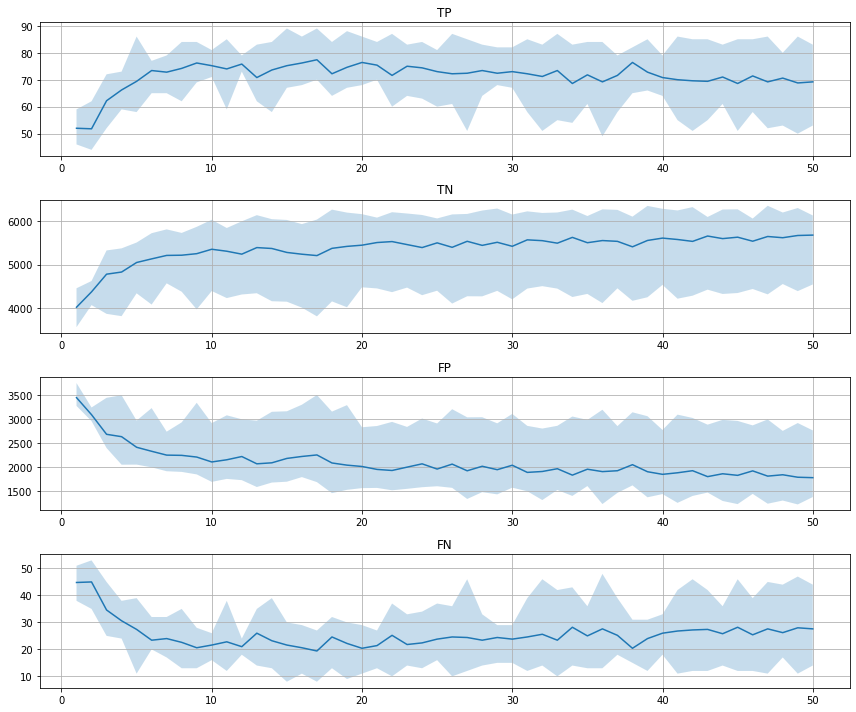

NameError: name 'list_results' is not defined

In [22]:
## find optimimum PCA value for RF
list_results = vary_pca(1,90, methods = ['RF-0'])